,country,0.999Q,iQ999,Deaths at Q999,FirstDeath,p,alpha,loc,scale
0,China,2020-04-13,104,239.367023,2020-01-21,5.419937,4.713006,27.733342,37.123565
1,Netherlands,2020-04-13,104,124.531719,2020-03-15,4.877867,8238.521417,78.810496,43623.744952


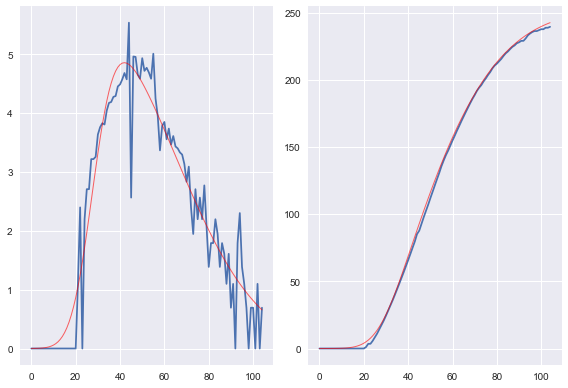

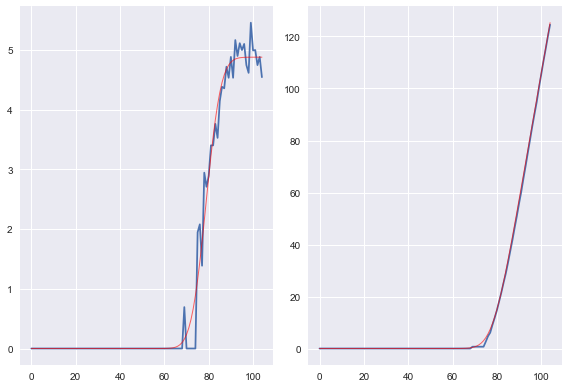

In [54]:
%reset -f

import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.special as sp
import numpy as np
from matplotlib import style
from scipy.stats import skewnorm, poisson
style.use('seaborn')
def getXy(dfsel, country):
    xy = pd.DataFrame(columns = ['dateRep','deaths'])
    xy['dateRep'] = pd.to_datetime(dfsel['dateRep'], format = "%d/%m/%Y" )
    xy['deaths'] = np.log(dfsel['deaths'])
    xy['deaths'].replace(-np.inf, 0.0, inplace=True)
    xy['deaths'].replace(np.nan, 0.0, inplace=True)
#     print(xy['deaths'])
    xy = xy.sort_values(by = 'dateRep')
    xy = xy.reset_index().drop(['index'], axis = 1)
    return xy

def getSkew(df, country):
    dfsel = df.loc[df['countriesAndTerritories'] == country]
    xy = getXy(dfsel, country)
    x = np.array(range(len(xy['dateRep'])))
    y = xy['deaths']
    
    # weighted arithmetic mean (corrected - check the section below)
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
    alpha = 0

    popt,pcov = curve_fit(skew, x, y, p0=[max(y), 0, mean, sigma], maxfev = 10000)
    
    total_deaths = max(xy['deaths'].cumsum())
    firstDeath = np.where(y >= 1)[0][0]
    quantile999 = np.where(xy['deaths'].cumsum() >= 0.999*xy['deaths'].cumsum().max())[0][0]

    return [country,
                xy['dateRep'][quantile999],
                quantile999, 
                xy['deaths'].cumsum()[quantile999],
                xy.iloc[firstDeath]['dateRep'], 
                popt[0], 
                popt[1], 
                popt[2], 
                popt[3]], total_deaths

def skew(x, k, alpha, x0, sigma):
        return k * np.exp(-(x - x0)**2 / (2 * sigma**2))*0.5*(1+sp.erf((alpha*(x-x0))/(sigma*np.sqrt(2))))

countries = ['China']#, 'Italy', 'Netherlands', 'France', 'Germany']

df = pd.read_csv("input\download.csv")

outcolumns = ['country', '0.999Q', 'iQ999', 'Deaths at Q999', 'FirstDeath', 'p', 'alpha', 'loc', 'scale']
results = []
totaldeaths = pd.DataFrame(columns = countries)

for country in countries:
    results.append(getSkew(df, country)[0])
    totaldeaths.loc[0,country] = getSkew(df, country)[1]
    
results = pd.DataFrame(results, columns = outcolumns)      
results

style.use('seaborn')

def plotCurve(xy, p, alpha, loc, scale):
    x = np.array(range(len(xy['dateRep'])))

    fig, ax = plt.subplots()
    
    plt.subplot(1,2,1)
    plt.plot(x, xy['deaths'], label = str(country) + ' actual')
    plt.plot(x, skew(x, p, alpha, loc, scale),
            'r-', 
            lw=1, 
            alpha=0.6, 
            label= str(country) + ' fit')
    plt.label = str(country) + ' fit'
    plt.title = str(country) + ' actual vs fit deaths per day'
    
    plt.subplot(1,2,2)
    plt.plot(x, xy['deaths'].cumsum(), label = str(country) + ' actual')
    plt.label = str(country) + ' actual'
    
    plt.plot(x, skew(x, p, alpha, loc, scale).cumsum(),
            'r-', 
            lw=1, 
            alpha=0.6, 
            label= str(country) + ' fit')
    plt.label = str(country) + ' fit'
    plt.title = str(country) + ' actual vs fit cumulative deaths'
    plt.tight_layout()
#     leg = ax.legend()
             
for country in countries:
    p = results.loc[results['country'] == country, 'p'].item()
    alpha = results.loc[results['country'] == country, 'alpha'].item()
    loc = results.loc[results['country'] == country, 'loc'].item()
    scale = results.loc[results['country'] == country, 'scale'].item()
    dfsel = df.loc[df['countriesAndTerritories'] == country]
    xy = getXy(dfsel, country)
    plotCurve(xy, p, alpha, loc, scale)

results    

logp = -10,917, ||grad|| = 104.04: 100%|██████████| 7/7 [00:00<00:00, 57.41it/s]   
Sequential sampling (2 chains in 1 job)
NUTS: [death_rate, asympt, scale, loc, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [06:10<00:00,  8.09it/s] 
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Initial Estimates for the Hamiltonian Monte Carlo
{'alpha': array(4.71418225), 'loc': array(78.86872034), 'scale': array(37.08891119), 'asympt': array(5.41993691), 'death_rate': array(-233.22472289)}


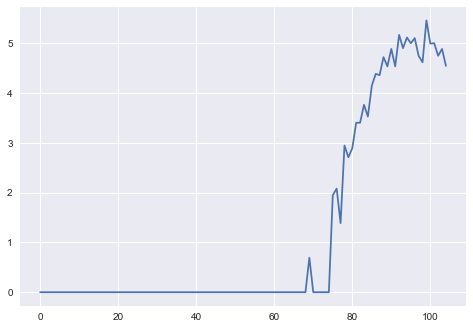

In [55]:
#MCMC Simulation
from pymc3 import Model, Normal, SkewNormal, Poisson, find_MAP, NUTS, sample, HamiltonianMC, traceplot, summary
from pymc3.math import exp
from scipy import optimize
import math
import pylab as pl
# Intialize random number generator
np.random.seed(7)

#True param values from prior
alpha_init =  results[results['country'] == 'China']['alpha'].item()
loc_init = results[results['country'] == 'China']['loc'].item()
scale_init = results[results['country'] == 'China']['scale'].item()
p_init = results[results['country'] == 'China']['p'].item()

est_country = "Netherlands"
xy_obs = getXy(df[df['countriesAndTerritories']==est_country], est_country)

y_act = xy_obs['deaths']
plt.plot(y_act)
basic_model = Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=alpha_init, sd=10)
    loc = Normal('loc', mu=78.8, sd=10)
    scale = Normal('scale', mu=scale_init, sd=10)
    p = Normal('asympt', mu=p_init, sd=10)
    # likelihood
    death_rate = SkewNormal('death_rate',mu = loc, sigma = scale, alpha = alpha)
    # posterior (sampling distribution) of observations
    y_obs = Poisson('y_obs', mu = death_rate, observed=y_act)
    # obtain starting values via MAP 
    start = find_MAP(model = basic_model)
    
    # instantiate sampler 
    step = NUTS()
    # draw 2000 posterior samples 
    trace = sample(2000, tune=1000, init = 'adapt_diag', step= step, cores=1, chains =2)

print("Initial Estimates for the Hamiltonian Monte Carlo")
print(start)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019A76CB77B8>,
      dtype=object)

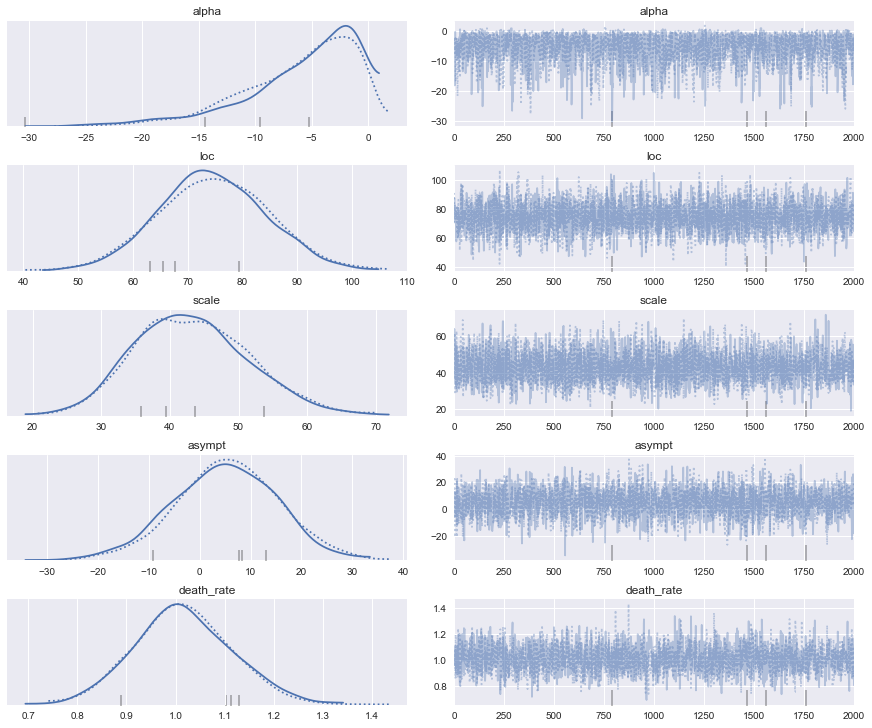

In [56]:
traceplot(trace)
# summary(trace)

In [57]:
summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-6.007,5.023,-15.165,0.986,0.139,0.103,1300.0,1187.0,1566.0,1421.0,1.0
loc,74.461,9.898,55.419,92.077,0.188,0.134,2780.0,2742.0,2788.0,2328.0,1.0
scale,43.129,8.206,28.508,58.702,0.165,0.120,2461.0,2339.0,2520.0,2230.0,1.0
asympt,5.057,9.953,-13.364,24.256,0.222,0.161,2017.0,1916.0,2028.0,1917.0,1.0
death_rate,1.014,0.098,0.837,1.204,0.002,0.001,2244.0,2185.0,2263.0,2320.0,1.0


Total Deaths = 3206.2925727529573
First death in Netherlands = 2020-03-06 00:00:00
Date where death rate will be less than 0.5%% = 2020-05-11 00:00:00


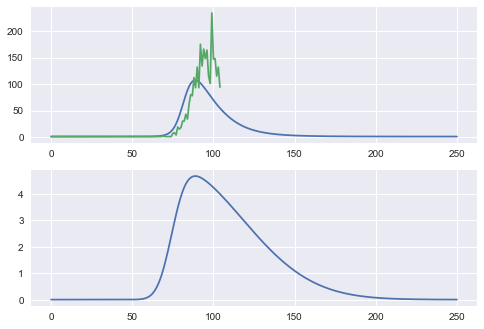

In [107]:
# style.use('default')
# estimates
alpha_est = -trace['alpha'].mean()
loc_est = trace['loc'].mean()
scale_est = trace['scale'].mean()
asympt_est = trace['asympt'].mean()

# skew(x, k, alpha, x0, sigma):
x = np.linspace(0,250, 250).astype(int)
xa = range(len(y_act))
s_rate = skew(x, k = asympt_est, alpha = alpha_est, x0 = loc_est, sigma = scale_est)
s_total = np.exp(s_rate)
deaths_act = np.exp(y_act)

plt.subplot(2,1,1)
plt.plot(x, s_total)
plt.plot(xa, deaths_act)
print("Total Deaths = " + str(s_total.cumsum().max()))

plt.subplot(2,1,2)
plt.plot(x, s_rate)

from datetime import datetime
from datetime import timedelta

fdDRlt1 = xy['dateRep'][0] + timedelta(days = int(np.where(s_rate[100:,] < 0.005)[0].min() -3))
fdinNL = xy['dateRep'][0] + timedelta(days = int(np.where(deaths_act > 1)[0].min() -3))

print("First death in Netherlands = " + str(fdinNL))
print("Date where death rate will be less than 0.5%% = " + str(fdDRlt1))


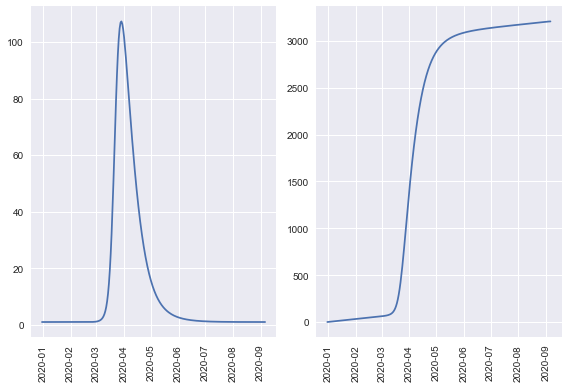

In [115]:

xdate = [0]*len(x)
for i in range(len(x)):
    xdate[i] = xy['dateRep'][0] + timedelta(days = x[i].astype(np.float64))
plt.subplot(1,2,1)
plt.plot(xdate, s_total)
plt.xticks(rotation=90)
# plt.title("Deaths per day - Estimated")
plt.subplot(1,2,2)
plt.plot(xdate, s_total.cumsum())
plt.xticks(rotation=90)
# plt.title('Total Cumulative Deaths - Estimated')
plt.tight_layout()